In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

import tensorflow
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing

from keras.layers import LSTM
from keras.layers import TimeDistributed

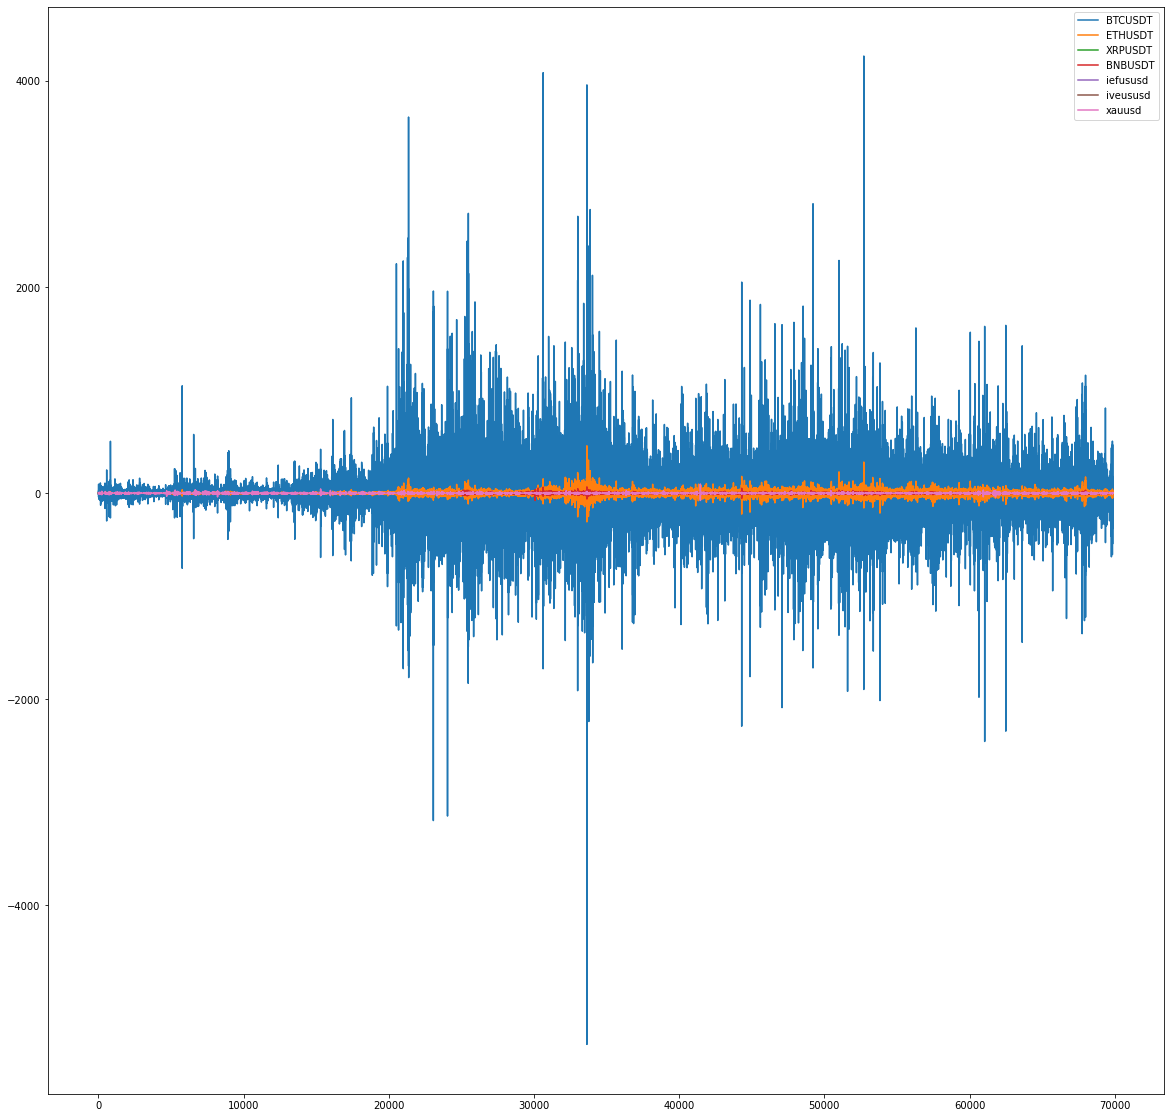

In [18]:
df = pd.read_csv('../data/test_data.csv', index_col=0)

df[df.columns[1:]] = df[df.columns[1:]].diff(periods=1, axis=0)
df[df.columns[1:]].diff(periods=1).plot(figsize=(20,20))
df.dropna(inplace=True)


In [22]:
df['timestamp'].iloc[0]

1591150500000.0

In [23]:
scaler = StandardScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])


In [17]:
df

,timestamp,BTCUSDT,ETHUSDT,XRPUSDT,BNBUSDT,iefususd,iveususd,xauusd
1,-1.732026,-0.098922,-0.110648,-0.121030,-0.048832,0.007671,-0.004683,-1.128475
2,-1.731976,0.005578,0.030229,0.028798,0.007710,0.007671,-0.004683,0.048147
3,-1.731927,0.047846,0.044720,0.072769,0.023029,0.007671,-0.004683,0.958050
4,-1.731877,-0.049100,-0.051882,-0.108001,-0.006744,0.007671,-0.004683,0.037299
5,-1.731828,0.006718,-0.026926,0.007627,-0.014835,0.007671,-0.004683,0.158535
...,...,...,...,...,...,...,...,...
69875,1.731828,0.252410,0.270123,0.178626,0.455818,0.007671,-0.004683,0.385053
69876,1.731877,0.204986,0.337744,0.341482,0.557603,0.007671,-0.004683,-0.275361
69877,1.731927,-0.172485,-0.371471,-0.407657,-0.307569,0.007671,-0.004683,-0.332788
69878,1.731976,0.217396,-0.003581,0.276340,0.201356,0.007671,-0.004683,0.043680


In [10]:
def sliding_window(df, windows_size, future_counter=4, frac=0.4):
    flag = True
    start_idx = 0
    X = []
    y = []
    counter = 0
    while flag:
        counter += 1
        X.append(df[start_idx: start_idx+windows_size])
        y.append(df[start_idx+windows_size: start_idx+windows_size+future_counter, 2])
        start_idx += int(frac*windows_size)
        if start_idx + windows_size > df.shape[0]:
            flag = False
        if counter % 1000 == 0:
            print(start_idx / (df.shape[0] - windows_size))

    return np.array(X)[:-1], np.array(y)[:-1]

X, y = sliding_window(df.values, 48)

0.2720854634761066
0.5441709269522133
0.8162563904283198


In [166]:
def make_seq_data(X, y, seq_len=150):
    X_seq = []
    y_seq = []
    for i in range(X.shape[0] - seq_len -1):
        X_seq.append(X[i: seq_len+i])
        y_seq.append(y[seq_len+i-1])

    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = make_seq_data(X, y, 10)

In [101]:
X_train = X_seq[:-100]
X_test = X_seq[-100:]

y_train = y_seq[:-100]
y_test = y_seq[-100:]

In [109]:
verbose, epochs, batch_size = 1, 100, 4
n_timesteps, n_features, n_outputs = 48, 4, 1
n_steps, n_length = 10, 48

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=512, kernel_size=3, activation='relu'), input_shape=(n_steps,n_length,n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Conv1D(filters=256, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(512, input_shape=(n_timesteps,n_features), return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(n_outputs, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
# fit network
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
# evaluate model
_, asd = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)



Epoch 1/100
200/200 [==============================] - 3s 7ms/step - loss: 1.0212 - mse: 1.0212

KeyboardInterrupt: 

In [228]:

optimizer = tensorflow.keras.optimizers.Nadam(learning_rate=0.001)

model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(48, 8)))
model.add(Dropout(0.3))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu',))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='linear'))

model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

In [11]:
X_train = X[:-100,:,:]
y_train = np.stack(y[:-100]).reshape(-1, 4)
X_test = X[-100:, :, :]
y_test = np.stack(y[-100:]).reshape(-1, 4)
# model.fit(X_train, y_train, epochs=200, batch_size=32)

In [169]:
np.stack(y_train)[0]

array([-0.07705967,  0.07220735, -0.03974292, -0.03974292])

112/112 [==============================] - 0s 1ms/step


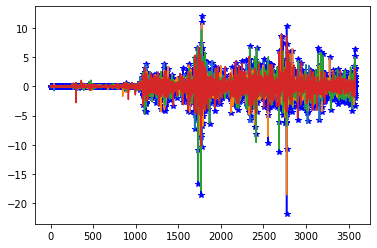

In [230]:
import matplotlib.pyplot as plt

plt.plot(model.predict(X_train), color='b', marker='*')
plt.plot(y_train)

4/4 [==============================] - 0s 5ms/step


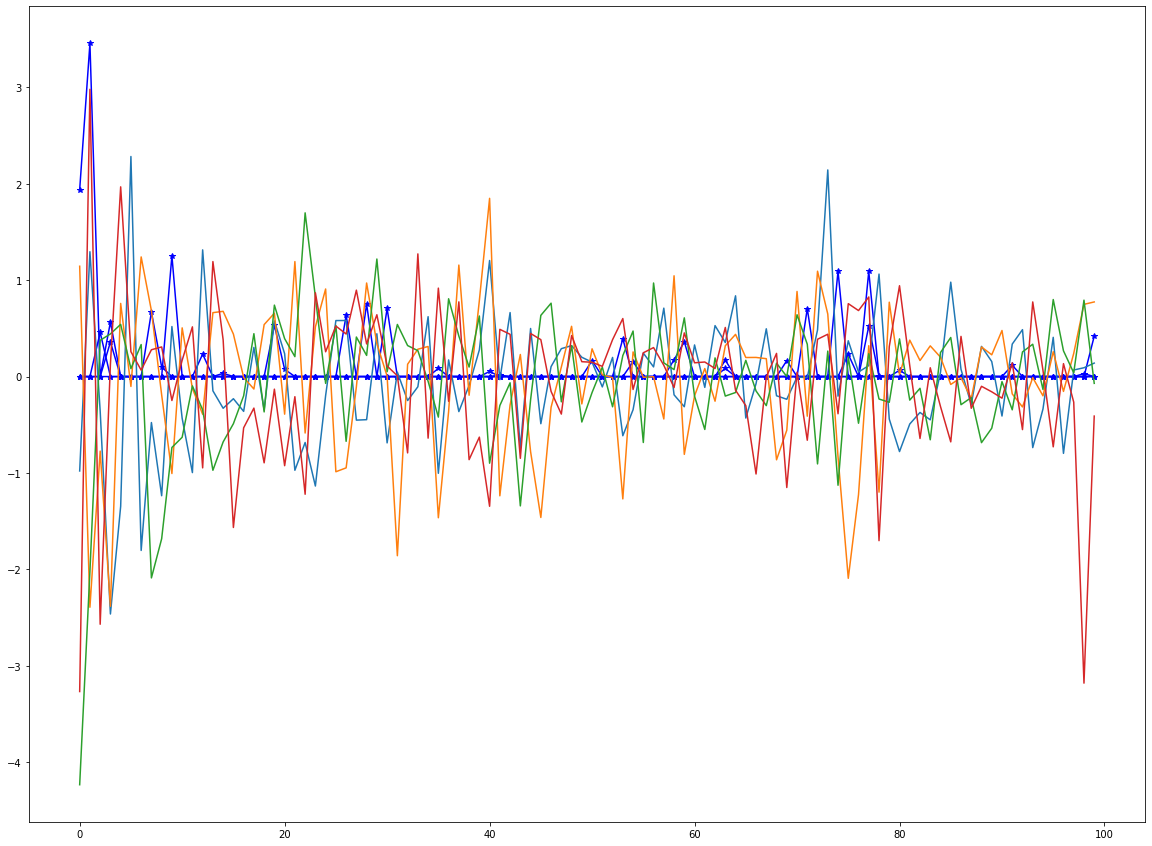

In [225]:
plt.figure(figsize=(20,15))
plt.plot(model.predict(X_test), color='b', marker='*')
plt.plot(y_test)

1/1 [==============================] - 0s 13ms/step


/tmp/ipykernel_34072/1525903372.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


1/1 [==============================] - 0s 16ms/step


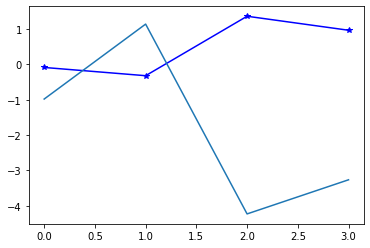

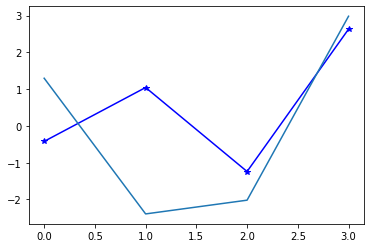

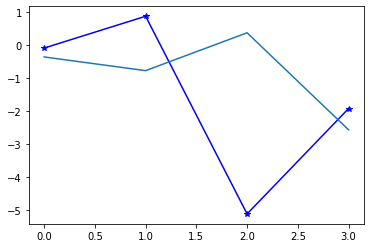

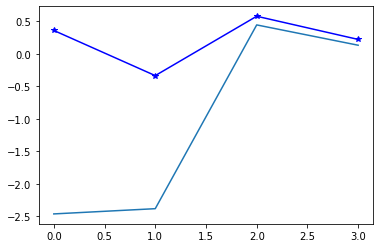

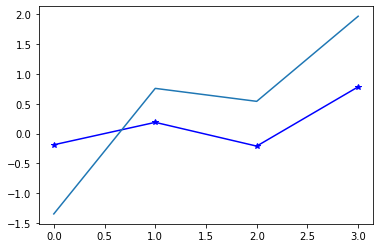

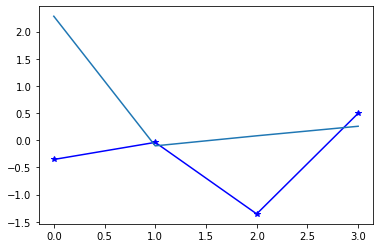

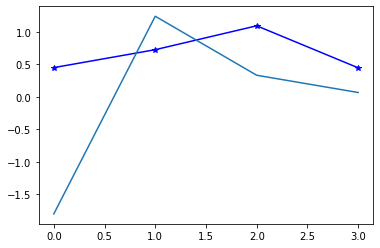

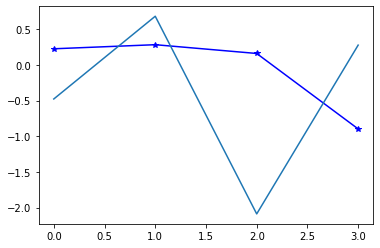

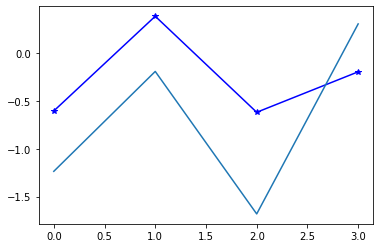

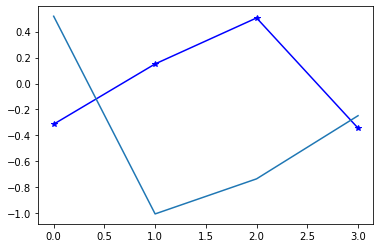

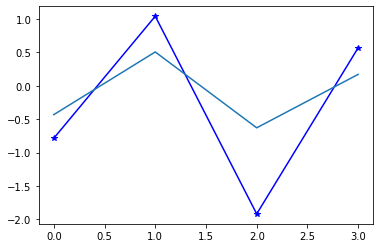

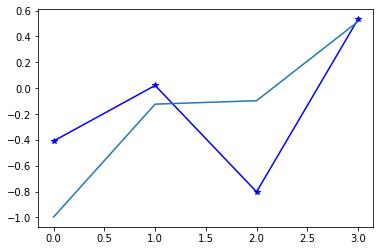

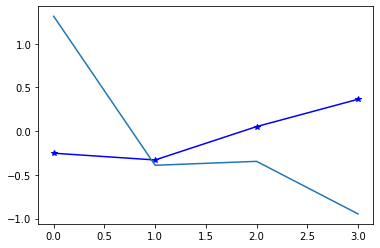

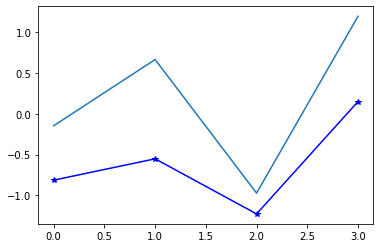

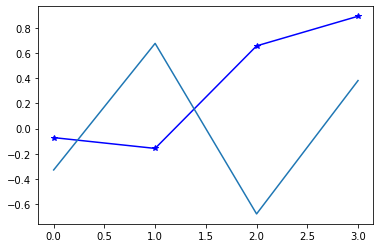

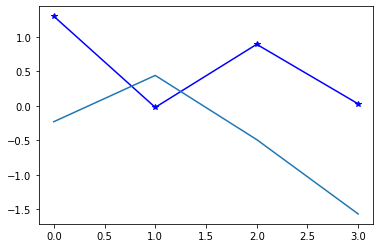

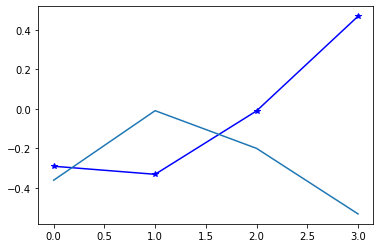

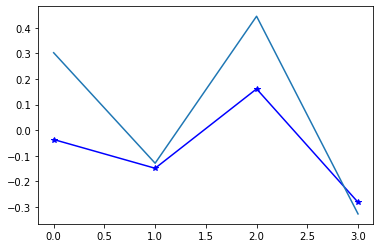

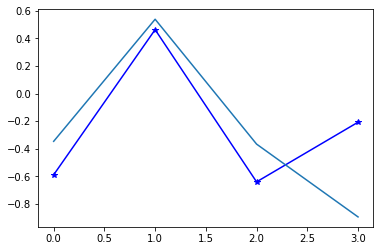

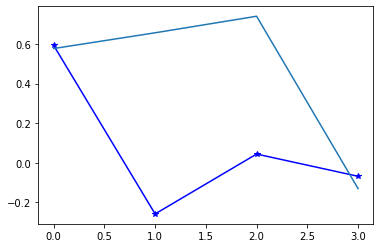

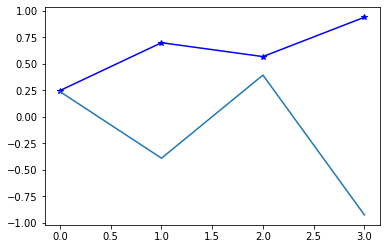

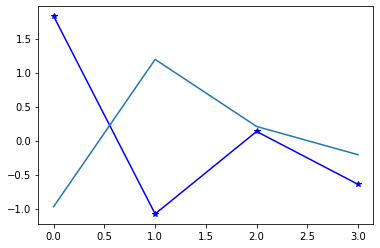

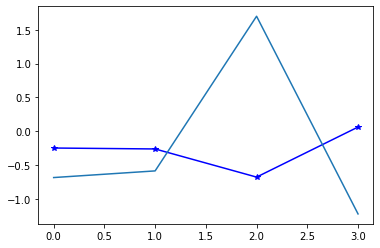

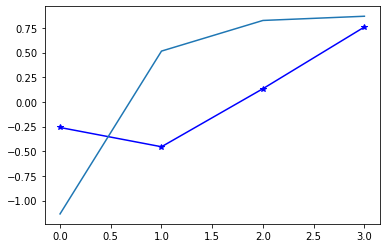

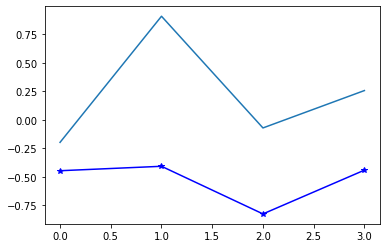

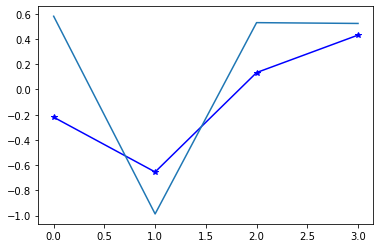

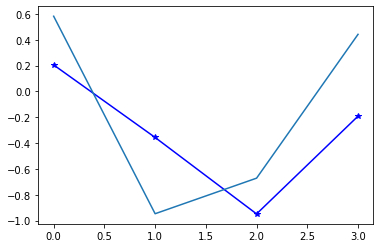

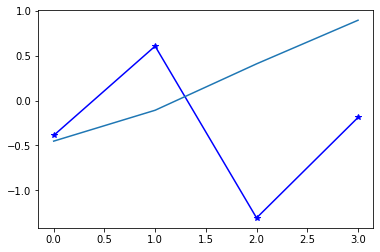

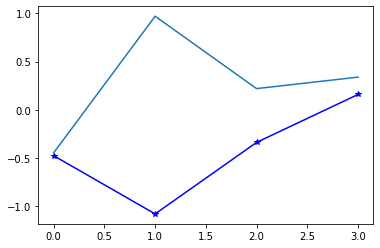

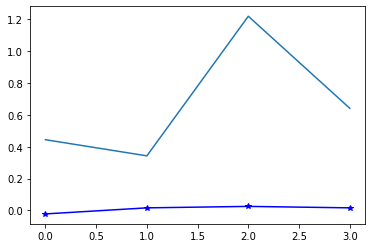

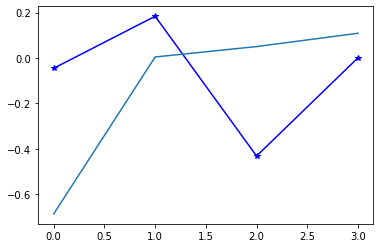

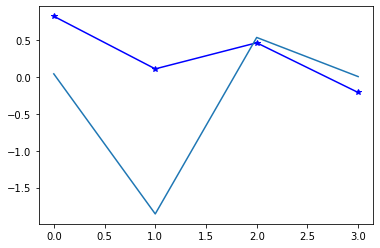

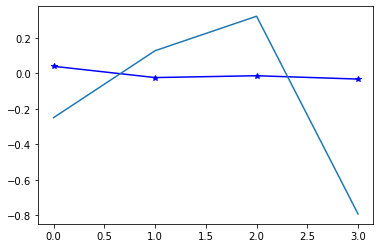

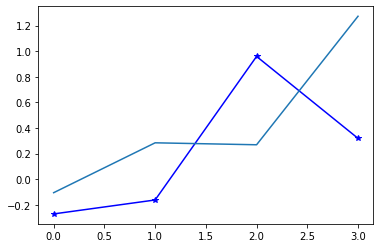

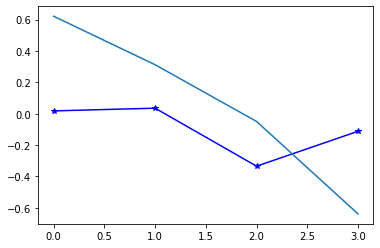

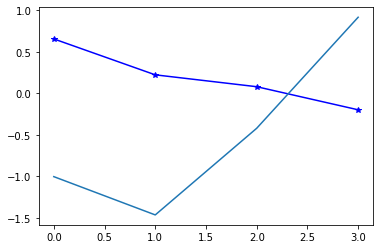

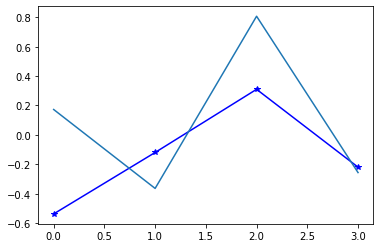

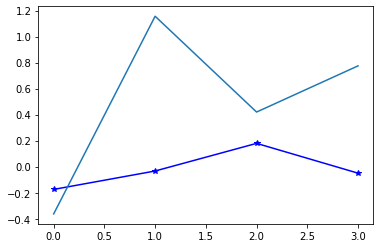

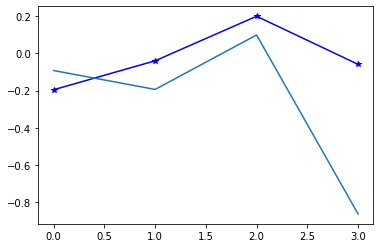

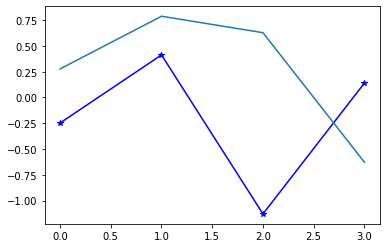

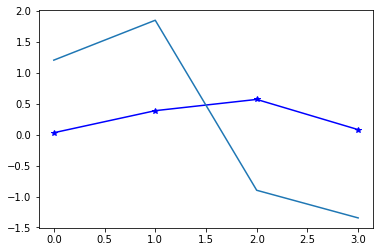

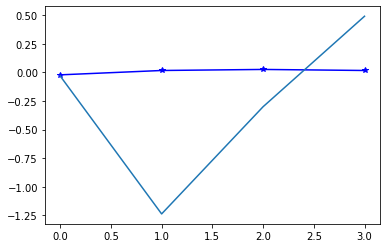

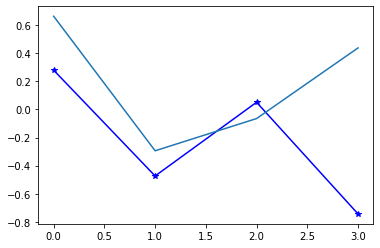

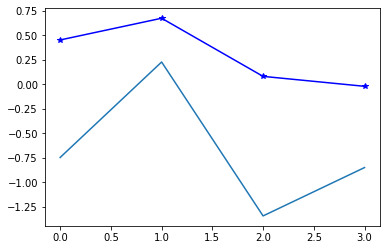

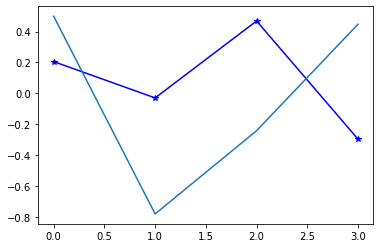

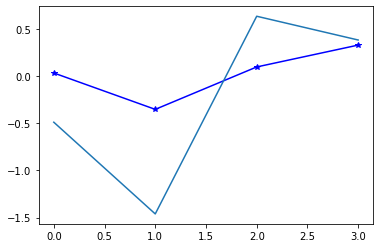

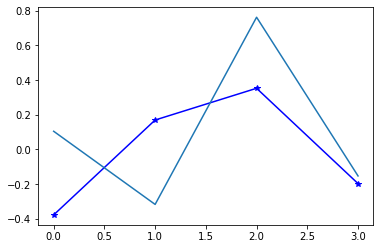

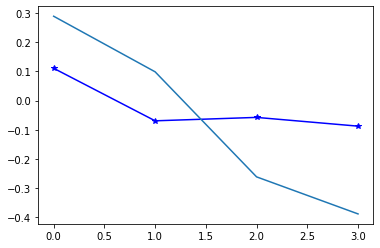

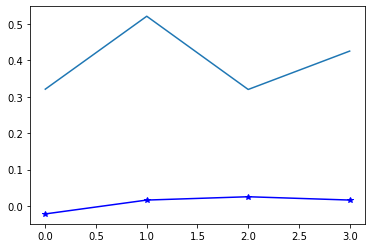

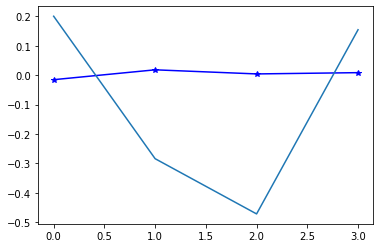

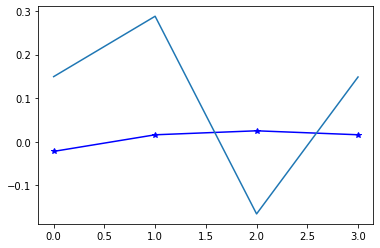

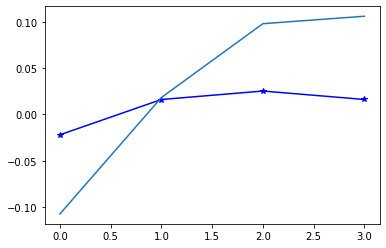

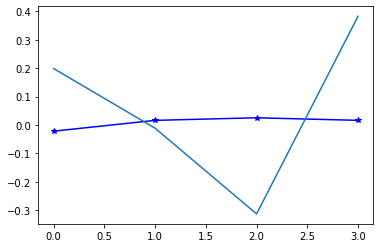

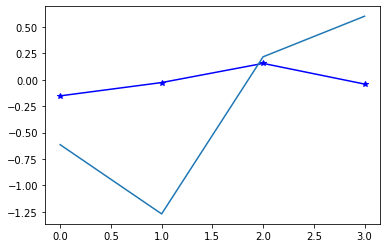

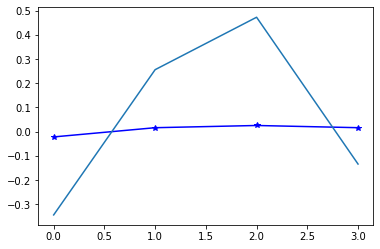

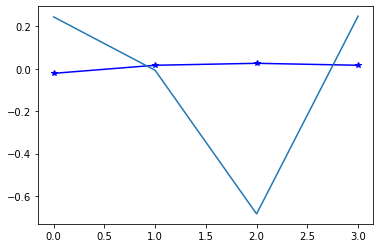

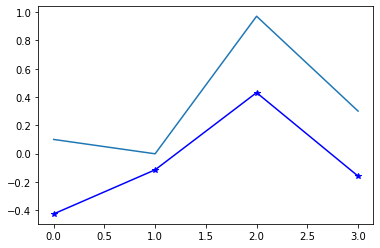

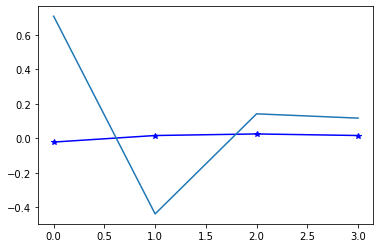

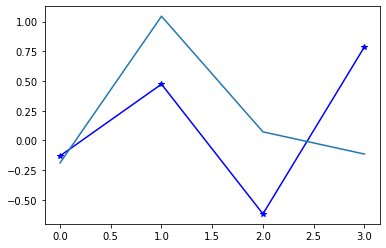

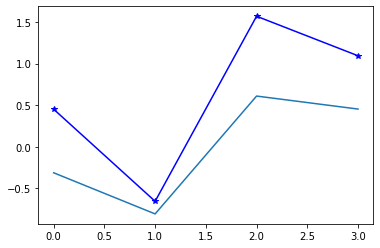

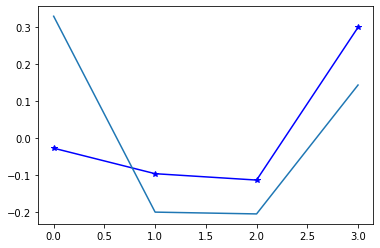

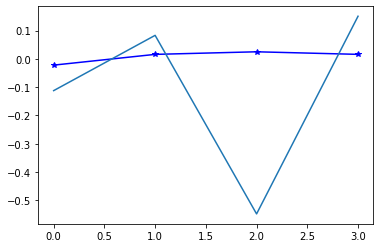

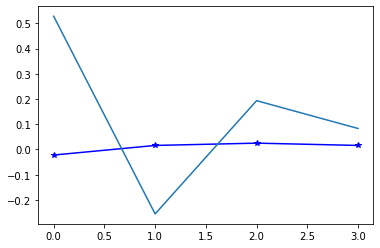

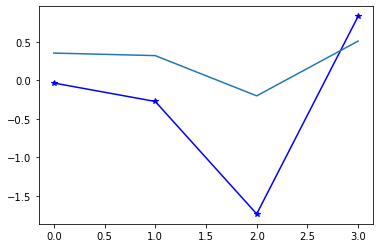

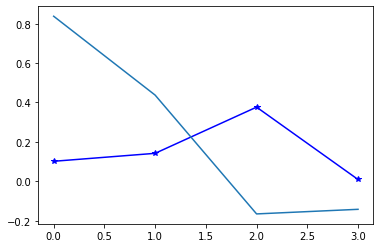

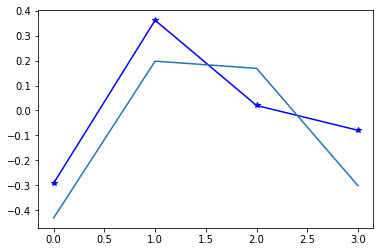

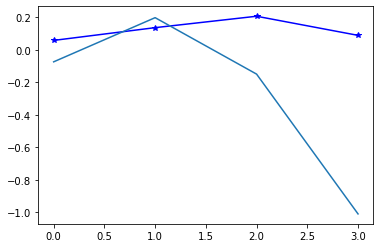

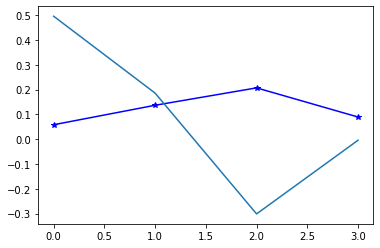

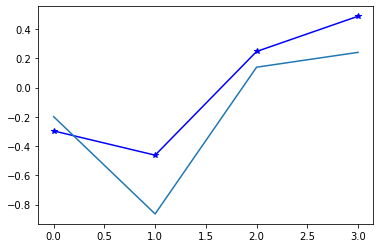

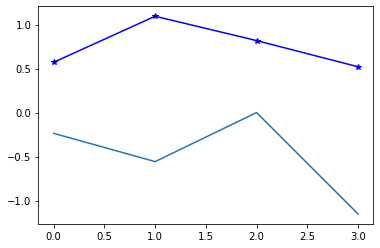

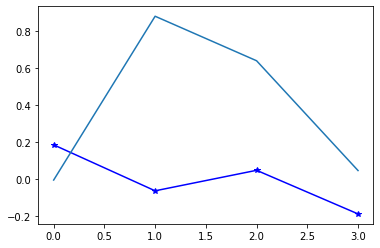

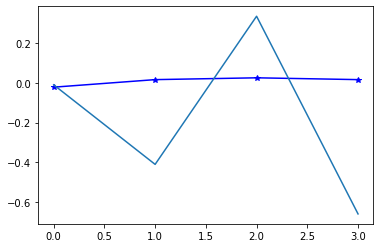

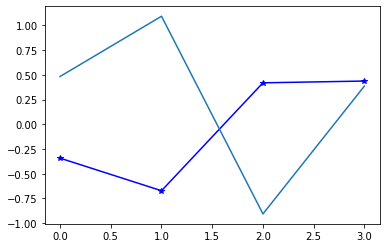

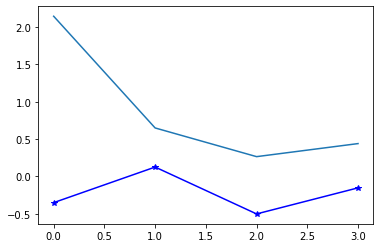

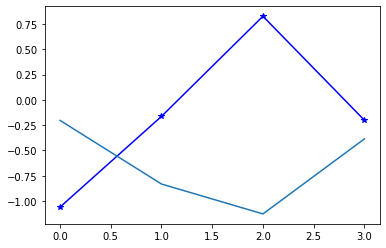

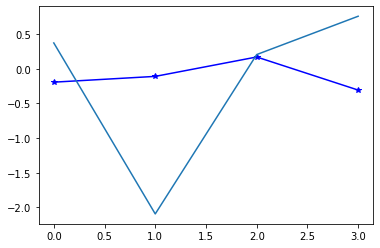

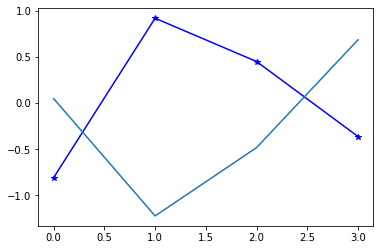

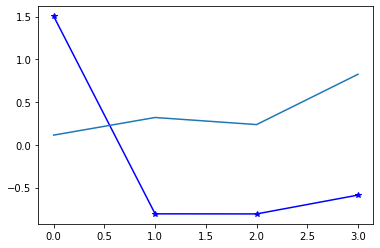

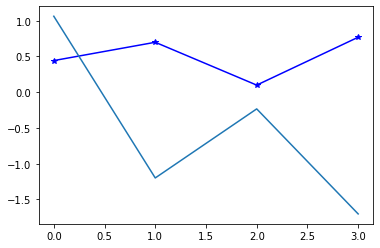

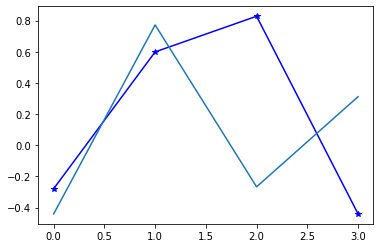

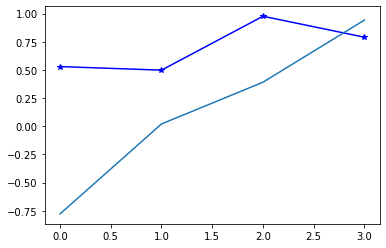

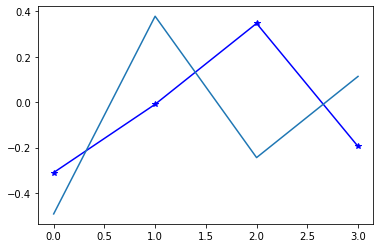

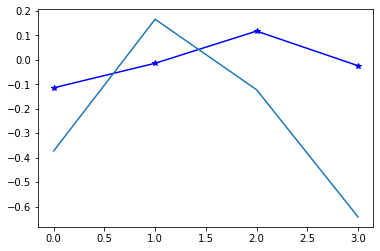

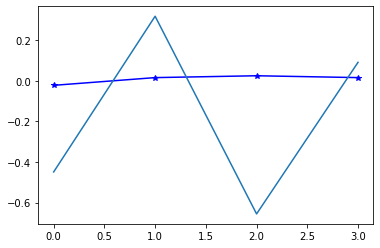

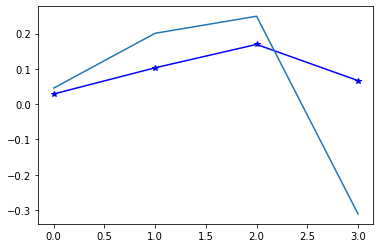

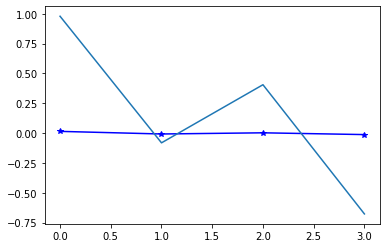

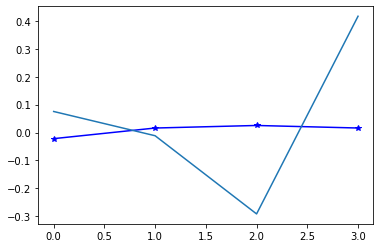

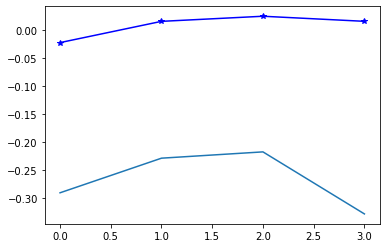

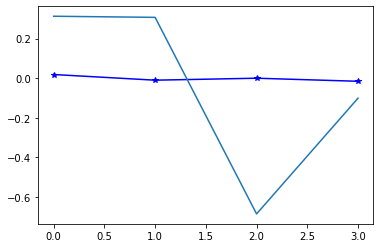

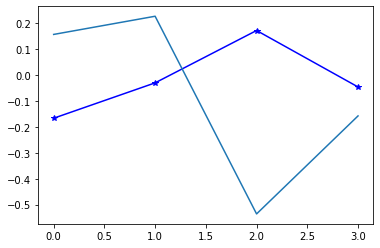

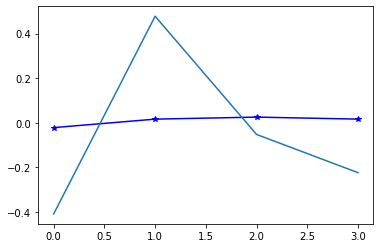

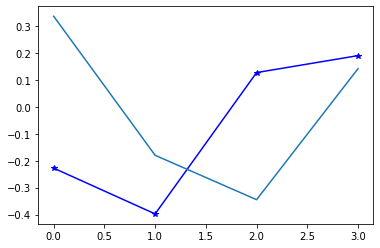

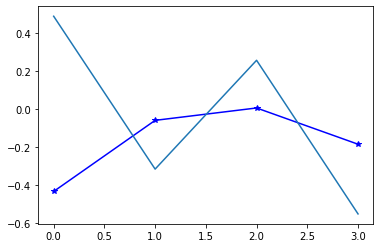

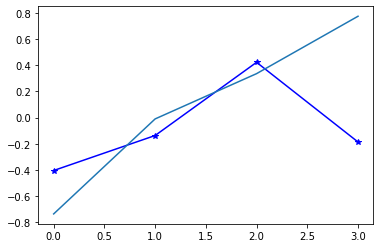

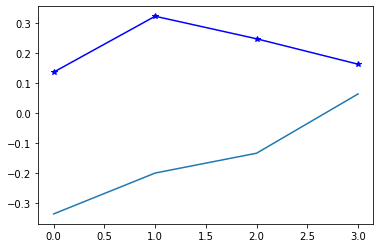

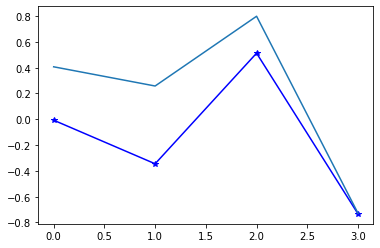

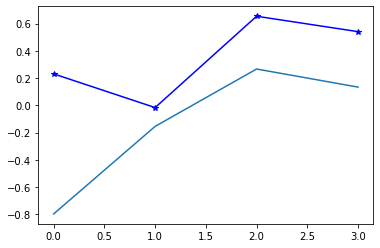

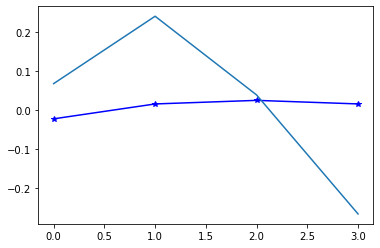

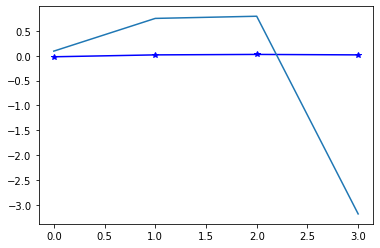

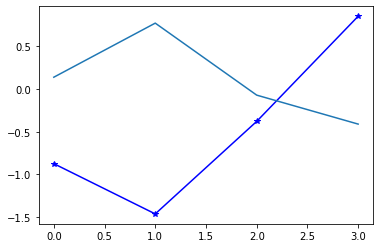

In [231]:
for i, j in zip(X_test, y_test):
    plt.figure()
    plt.plot(model.predict(np.expand_dims(i, 0))[0], color='b', marker='*')
    plt.plot(j)

In [233]:

model.save('../models/test_model.h5')

In [12]:

from tensorflow.keras.models import load_model

In [13]:
asd = load_model('../models/test_model.h5')

In [14]:
ss = asd.predict(np.array([X_test[0]]))

2022-08-11 20:42:08.968699: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-11 20:42:09.533776: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 2s 2s/step


2022-08-11 20:42:10.039699: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [11]:
import joblib
my_scaler = joblib.load('../models/scaler.gz')


In [12]:
import numpy as np
import pandas as pd
my_scaler.transform(pd.DataFrame((np.ones((3, 1)) + np.array([1, 2, 3]).T)).diff().dropna())

/home/karol/PycharmProjects/faces/venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: X has 3 features, but StandardScaler is expecting 8 features as input.

In [22]:

ss.sum()

1.936219

In [23]:
ss

array([[-0.08387785, -0.31759194,  1.3671864 ,  0.9705023 ]],
      dtype=float32)

In [31]:
np.concatenate([np.zeros((2,4)), ss, np.zeros((5,4))]).T

array([[ 0.        ,  0.        , -0.08387785,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.31759194,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.36718643,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.97050232,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ]])

In [35]:
my_scaler.inverse_transform(np.concatenate([np.zeros((2,4)), ss, np.zeros((5,4))]).T)

array([[ 1.62259560e+12,  3.19550652e-01, -1.01746092e+00,
         3.16790452e-06,  4.35050587e-03, -2.61595043e-04,
         5.57807067e-04,  1.54485611e-03],
       [ 1.62259560e+12,  3.19550652e-01, -3.92069970e+00,
         3.16790452e-06,  4.35050587e-03, -2.61595043e-04,
         5.57807067e-04,  1.54485611e-03],
       [ 1.62259560e+12,  3.19550652e-01,  1.70079225e+01,
         3.16790452e-06,  4.35050587e-03, -2.61595043e-04,
         5.57807067e-04,  1.54485611e-03],
       [ 1.62259560e+12,  3.19550652e-01,  1.20802406e+01,
         3.16790452e-06,  4.35050587e-03, -2.61595043e-04,
         5.57807067e-04,  1.54485611e-03]])

In [18]:

!pip list

Package                      Version
---------------------------- -----------
absl-py                      1.2.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
asttokens                    2.0.5
astunparse                   1.6.3
attrs                        22.1.0
backcall                     0.2.0
beautifulsoup4               4.11.1
bleach                       5.0.1
cachetools                   5.2.0
certifi                      2022.6.15
cffi                         1.15.1
charset-normalizer           2.1.0
click                        8.1.3
coloredlogs                  15.0.1
cycler                       0.11.0
debugpy                      1.6.2
decorator                    5.1.1
defusedxml                   0.7.1
dlib                         19.24.0
entrypoints                  0.4
executing                    0.9.1
face-recognition             1.3.0
face-recognition-models      0.3.0
fastjsonschema               2.16.1
flatbuffers                  1.12
f